# Single label Classifier (Multiple leads) - AF Detection

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [24]:
import sys
sys.path.append("../../tutorials/fastai/old/") # go to parent dir

from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer

import mlflow
import mlflow.sklearn

## Helper functions

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [4]:
def print_fscores(m, X_valid, y_valid):
    res = [f1_score(y_valid, m.predict(X_valid), average='weighted'), fbeta_score(y_valid, m.predict(X_valid), beta=2)]
    print(res)

### Lead data:

In [5]:
df_raw_1 = pd.read_feather('datasets/corrected/pyhs-raw-lead1-corrected')
df_raw_2 = pd.read_feather('datasets/corrected/pyhs-raw-lead2-corrected')
df_raw_3 = pd.read_feather('datasets/corrected/pyhs-raw-lead3-corrected')
df_raw_aVR = pd.read_feather('datasets/corrected/pyhs-raw-leadAVR-corrected')

In [6]:
df_raw_1['PT_duration'] = df_raw_1['mean_T_Offsets'] - df_raw_1['mean_P_Onsets']
df_raw_1.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

df_raw_2['PT_duration'] = df_raw_2['mean_T_Offsets'] - df_raw_2['mean_P_Onsets']
df_raw_2.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

df_raw_3['PT_duration'] = df_raw_3['mean_T_Offsets'] - df_raw_3['mean_P_Onsets']
df_raw_3.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

df_raw_aVR['PT_duration'] = df_raw_aVR['mean_T_Offsets'] - df_raw_aVR['mean_P_Onsets']
df_raw_aVR.drop(['mean_T_Offsets', 'mean_P_Onsets'], axis=1, inplace=True)

### We join all these datasets together

In [7]:
com_cols = ['age', 'sex', 'label']

df_com = df_raw_1[com_cols]

In [8]:
lead_cols = ['fmax', 'mean_RR', 'mean_R_Peaks', 'mean_T_Peaks', 'mean_P_Peaks', 'mean_Q_Peaks', 'mean_S_Peaks', 'median_RR', 'median_R_Peaks', 'std_RR', 'std_R_Peaks', 'var_RR', 'var_R_Peaks', 'skew_RR', 'skew_R_Peaks', 'kurt_RR', 'kurt_R_Peaks', 'PT_duration', 'HRV']

df_raw_1 = df_raw_1[lead_cols].add_suffix('_l1')
df_raw_2 = df_raw_2[lead_cols].add_suffix('_l2')
df_raw_3 = df_raw_3[lead_cols].add_suffix('_l3')
df_raw_aVR = df_raw_aVR[lead_cols].add_suffix('_laVR')

In [9]:
df_aux = df_com.join(df_raw_1)

df_aux2 = df_aux.join(df_raw_2)

df_aux3 = df_aux2.join(df_raw_3)

df_merge = df_aux3.join(df_raw_aVR)

display_all(df_merge.T)

0            1            2            3     \
age                           64           24           59           14   
sex                            1            1            0            1   
label                        PAC       Normal          PAC       Normal   
fmax_l1                  8.20328      2.15043      1.05485      7.64504   
mean_RR_l1               4460.78      9963.95      7031.67      6695.09   
mean_R_Peaks_l1           190690       161291       228946  4.04914e+06   
mean_T_Peaks_l1          84.1667      183.905      120.467      56.7143   
mean_P_Peaks_l1          77.6667      44.0476      58.7333      57.1905   
mean_Q_Peaks_l1           -32.75     -38.1905        -36.2     -148.619   
mean_S_Peaks_l1         -46.6667     -212.048     -130.267     -121.952   
median_RR_l1                4017         9914         6993         6660   
median_R_Peaks_l1         163434       245336       183364  4.22689e+06   
std_RR_l1                2788.58      5793.79      4059.13      4090.41   
std_R_Peaks_l1            170403       120275       214377       884262   
var_RR_l1            8.23363e+06  3.43673e+07  1.70447e+07  1.75282e+07   
var_R_Peaks_l1       3.07451e+10  1.48104e+10  4.75421e+10  8.19154e+11   
skew_RR_l1              0.326896   0.00822937    0.0160395    0.0310137   
skew_R_Peaks_l1         0.452789   -0.0122815     0.102263     -4.32584   
kurt_RR_l1               -1.1146     -1.19623     -1.17866     -1.22044   
kurt_R_Peaks_l1         -1.28517     -1.95524     -1.85952      16.8351   
PT_duration_l1             488.5      466.667      519.333      453.048   
HRV_l1                   300.262      252.052       247.39      319.845   
fmax_l2                  4.60184      1.05021      1.05485      4.57274   
mean_RR_l2               5164.82      9965.07      7262.19         6977   
mean_R_Peaks_l2      3.21419e+06  1.42354e+06       782051       544773   
mean_T_Peaks_l2          115.636       371.35      172.267      108.762   
mean_P_Peaks_l2          13.1818     -19.5714     -8.73333      44.0476   
mean_Q_Peaks_l2         -114.364     -114.714     -95.9333     -72.4762   
mean_S_Peaks_l2         -54.0909      -270.81     -39.0667     -157.095   
median_RR_l2                5166         9920         7150         7275   
median_R_Peaks_l2     4.3649e+06  2.37452e+06      43328.4       615665   
std_RR_l2                2986.46      5793.85      4186.15      4060.39   
std_R_Peaks_l2       2.39316e+06  1.26495e+06       779588       204638   
var_RR_l2            9.47635e+06   3.4368e+07   1.8108e+07  1.72036e+07   
var_R_Peaks_l2       6.08516e+12   1.6382e+12  6.28016e+11  4.36973e+10   
skew_RR_l2             0.0022395   0.00818842   0.00841972    -0.099483   
skew_R_Peaks_l2        -0.497951   -0.0336479     0.119925     -2.12018   
kurt_RR_l2              -1.25653     -1.19657     -1.19276     -1.21384   
kurt_R_Peaks_l2         -1.59331     -1.98235     -1.89579      2.76596   
PT_duration_l2           479.818          NaN      531.333       414.19   
HRV_l2                   324.786       250.69      244.448      297.769   
fmax_l3                  4.60184      1.05021       3.3052      3.07231   
mean_RR_l3               5338.44      10673.9      6929.33      7017.83   
mean_R_Peaks_l3      1.97854e+06       869375       286573  1.95442e+06   
mean_T_Peaks_l3          34.8333        184.1           57      27.4762   
mean_P_Peaks_l3         -10.8333     -43.5238     -52.0667      36.8095   
mean_Q_Peaks_l3         -79.0833     -68.4286     -65.4667     -34.1429   
mean_S_Peaks_l3            -2.75     -89.0952      1.93333     -810.714   
median_RR_l3                5586        10798         6549         6968   
median_R_Peaks_l3    2.35302e+06  1.44755e+06       203676  2.12784e+06   
std_RR_l3                 2785.3      5591.39      4116.58       4266.2   
std_R_Peaks_l3       1.70949e+06       738232       297286       607762   
var_RR_l3            8.21426e+06  3.20864e+07  1.7530

In [10]:
df_raw = df_merge.copy()

In [11]:
labels = pd.get_dummies(df_raw['label'])
labels.describe()

AF        I-AVB         LBBB       Normal          PAC  \
count  6877.000000  6877.000000  6877.000000  6877.000000  6877.000000   
mean      0.177548     0.104988     0.028937     0.133488     0.079104   
std       0.382160     0.306560     0.167642     0.340127     0.269921   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               PVC         RBBB          STD          STE  
count  6877.000000  6877.000000  6877.000000  6877.000000  
mean      0.091173     0.243566     0.114294     0.026901  
std       0.287877     0.429265     0.318191     0.161807  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000  
75%       0.000000     0.000000     0.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000

## Split between Train and Validation Datasets

### Training Set (80%) - Validation (20%)

In [12]:
df_af = df_raw[(df_raw.loc[:, 'label'] == 'AF')]
df_af.reset_index(inplace=True)
df_train_af = df_af.sample(frac=0.8)

id_train = list(df_train_af.index)
id_valid = [y for y in range(len(df_af)) if y not in id_train]
df_valid_af = df_af.loc[id_valid,:]
len(df_valid_af), len(df_train_af), len(df_af)

(244, 977, 1221)

In [13]:
df_rest = df_raw[(df_raw.loc[:, 'label'] != 'AF')]
df_rest.reset_index(inplace=True)
df_train_rest = df_rest.sample(frac=0.8)

id_train = list(df_train_rest.index)
id_valid = [y for y in range(len(df_rest)) if y not in id_train]

df_valid_rest = df_rest.loc[id_valid,:]
len(df_valid_rest), len(df_train_rest), len(df_rest)

(1131, 4525, 5656)

### We check to see if the labels we sampled in the same proportion as they appear in the original dataset

In [14]:
labels = pd.get_dummies(df_train_rest['label'])
labels.describe()

I-AVB         LBBB       Normal          PAC          PVC  \
count  4525.000000  4525.000000  4525.000000  4525.000000  4525.000000   
mean      0.129945     0.036243     0.161326     0.099890     0.112044   
std       0.336280     0.186915     0.367872     0.299886     0.315456   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              RBBB          STD         STE  
count  4525.000000  4525.000000  4525.00000  
mean      0.293481     0.135912     0.03116  
std       0.455407     0.342733     0.17377  
min       0.000000     0.000000     0.00000  
25%       0.000000     0.000000     0.00000  
50%       0.000000     0.000000     0.00000  
75%       1.000000     0.000000     0.00000  
max       1.000000     1.000000     1.00000

We've seen a variability of ~3% to 5%. Apparently there's a 0.01 to 0.02 of fluctuation in the model's score depending on how the datasets are sampled. We may consider changing the sampling to one that provides more robust and fiable results.

### Renaming everything else as "Non-AF" in both sets

In [15]:
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'I-AVB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'LBBB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'Normal'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'PAC'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'PVC'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'RBBB'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'STD'] = 'Non-AF'
df_train_rest['label'][df_train_rest.loc[:, 'label'] == 'STE'] = 'Non-AF'

df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'I-AVB'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'LBBB'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'Normal'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'PAC'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'PVC'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'RBBB'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'STD'] = 'Non-AF'
df_valid_rest['label'][df_valid_rest.loc[:, 'label'] == 'STE'] = 'Non-AF'

/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tom/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

### We merge both sets into one

In [16]:
df_train = pd.concat([df_train_af, df_train_rest])
df_valid = pd.concat([df_valid_af, df_valid_rest])
df_train.drop('index', inplace=True, axis=1)
df_valid.drop('index', inplace=True, axis=1)

df_train

age  sex   label   fmax_l1    mean_RR_l1  mean_R_Peaks_l1  \
108    60    1      AF  1.800720   5499.454545     7.373150e+04   
1133   73    0      AF  2.273554   5450.692308     3.296488e+05   
1146   70    1      AF  3.402380  23085.361702     1.046598e+06   
68     81    0      AF  1.615633  12968.175439     2.365785e+05   
734    84    1      AF  9.303721   4995.727273     7.585468e+05   
...   ...  ...     ...       ...           ...              ...   
4027   78    0  Non-AF  3.501000   6984.787879     1.002552e+06   
4438   73    0  Non-AF  1.400560   4642.823529     1.413030e+05   
13     35    0  Non-AF  7.502501   5674.592593     5.832589e+05   
2939   50    0  Non-AF  1.417139   5822.333333     1.570293e+06   
5455   76    0  Non-AF  5.177689   8513.863636     1.482062e+06   

      mean_T_Peaks_l1  mean_P_Peaks_l1  mean_Q_Peaks_l1  mean_S_Peaks_l1  ...  \
108          5.692308        25.692308       -36.307692       -60.923077  ...   
1133         5.045455        66.909091         7.500000      -198.454545  ...   
1146        58.559524         4.845238       -45.154762       -45.678571  ...   
68          55.642857        28.333333       -23.023810      -180.357143  ...   
734        105.416667        74.500000       -97.083333       -92.416667  ...   
...               ...              ...              ...              ...  ...   
4027       166.062500       -15.750000      -105.750000       -47.625000  ...   
4438        24.076923        50.692308       -43.153846      -143.384615  ...   
13         108.722222        98.444444       -80.666667      -166.944444  ...   
2939        48.375000        17.687500       -57.375000       -66.437500  ...   
5455        84.558140        84.116279       -16.465116      -318.162791  ...   

       std_RR_laVR  std_R_Peaks_laVR   var_RR_laVR  var_R_Peaks_laVR  \
108    3091.771495      51976.701209  1.001424e+07      2.830224e+09   
1133   3311.511914      70365.595163  1.140476e+07      5.149370e+09   
1146  13395.798137     681171.139791  1.814637e+08      4.692075e+11   
68     7406.895022     150514.475144  5.584177e+07      2.305915e+10   
734    2887.245351     378882.400140  8.733147e+06      1.503877e+11   
...            ...               ...           ...               ...   
4027   4161.602721     478980.374114  1.784375e+07      2.363744e+11   
4438   2841.582958     284464.513774  8.651350e+06      8.670006e+10   
13     3338.761626     320970.900075  1.157607e+07      1.069847e+11   
2939   3489.225230      75955.882574  1.293561e+07      6.129877e+09   
5455   4890.575716      56163.432902  2.447396e+07      3.227688e+09   

      skew_RR_laVR  skew_R_Peaks_laVR  kurt_RR_laVR  kurt_R_Peaks_laVR  \
108       0.149926          -0.424011     -1.278516          -1.579307   
1133      0.020861          -1.535784     -1.244769           0.942575   
1146     -0.039285          -2.090849     -1.161721           5.286213   
68        0.101233          -0.734067     -1.111981          -1.019959   
734      -0.146261           0.137250     -1.167891          -1.434652   
...            ...                ...           ...                ...   
4027     -0.013504           0.143266     -1.216433          -1.945361   
4438      0.060493          -3.056845     -1.100275           8.295004   
13       -0.089843          -0.656902     -1.224187          -1.498178   
2939      0.007889           0.253637     -1.211435          -0.965071   
5455     -0.001078          -0.799872     -1.199024           0.190813   

      PT_duration_laVR    HRV_laVR  
108         537.600000  247.876601  
1133        430.090909  221.868159  
1146        407.292683  268.351627  
68          473.095238  238.081994  
734         488.769231  244.198007  
...                ...         ...  
4027        564.375000  217.436511  
4438        370.769231  343.636332  
13          530.222222  222.873110  
2939        424.250000  356.487202  
5455        384.232558  192.764828  

[5502 rows x 79 columns]

In [17]:
df_valid

age  sex   label   fmax_l1    mean_RR_l1  mean_R_Peaks_l1  \
1      76    0      AF  1.800720   4782.454545     1.049831e+05   
12     73    0      AF  1.150230   9596.488889     2.448211e+04   
15     86    0      AF  4.093769  23321.361702     1.700317e+06   
17     64    0      AF  3.101240   5026.230769     2.931868e+05   
19     75    0      AF  3.501401   5348.173913     8.362954e+04   
...   ...  ...     ...       ...           ...              ...   
5646   69    0  Non-AF  5.200594  18425.900000     1.559735e+06   
5647   42    1  Non-AF  5.084503   6746.400000     1.698668e+05   
5650   69    0  Non-AF  2.801120   4876.909091     3.151775e+05   
5651   50    0  Non-AF  4.301721   4769.500000     4.155398e+05   
5652   30    0  Non-AF  2.885683   8786.444444     1.013361e+06   

      mean_T_Peaks_l1  mean_P_Peaks_l1  mean_Q_Peaks_l1  mean_S_Peaks_l1  ...  \
1           60.785714        67.642857       -26.357143      -129.214286  ...   
12          32.444444        11.416667       -40.416667       -23.500000  ...   
15          39.200000        -8.725000       -37.800000       -83.450000  ...   
17          66.473684        31.736842        17.421053       -78.421053  ...   
19          90.000000        31.916667       -27.583333       -12.333333  ...   
...               ...              ...              ...              ...  ...   
5646         2.969697        43.794118       -35.411765      -244.941176  ...   
5647        77.791667        14.458333       -47.583333       -38.291667  ...   
5650       136.928571        44.857143       -49.285714      -282.571429  ...   
5651        45.000000        24.000000       -48.272727       -15.818182  ...   
5652       209.880000        49.080000       -43.520000      -434.680000  ...   

       std_RR_laVR  std_R_Peaks_laVR   var_RR_laVR  var_R_Peaks_laVR  \
1      2847.858586      2.092895e+05  8.560871e+06      4.623553e+10   
12     5611.305787      2.562770e+04  3.220236e+07      6.717060e+08   
15    13182.175280      3.897733e+05  1.758384e+08      1.537318e+11   
17     2905.027111      1.713414e+05  8.763766e+06      3.048701e+10   
19     2964.217845      9.266573e+04  9.185978e+06      8.977253e+09   
...            ...               ...           ...               ...   
5646  10364.435099      7.693799e+05  1.092736e+08      6.021514e+11   
5647   4154.061896      5.199962e+05  1.797524e+07      2.816625e+11   
5650   2818.961034      4.075748e+05  8.252178e+06      1.725063e+11   
5651   3068.555160      6.983368e+05  1.020070e+07      5.283138e+11   
5652   5262.629990      1.318458e+06  2.837077e+07      1.780731e+12   

      skew_RR_laVR  skew_R_Peaks_laVR  kurt_RR_laVR  kurt_R_Peaks_laVR  \
1        -0.109226          -1.244278     -1.165543           0.377161   
12        0.047971          -0.975988     -1.150286           0.853502   
15        0.017636          -3.831763     -1.141521          14.001331   
17        0.039515          -1.882249     -1.206168           2.810038   
19       -0.147099           0.203336     -1.255068          -1.236031   
...            ...                ...           ...                ...   
5646     -0.144857          -0.089770     -1.213205          -1.976092   
5647      0.039330          -4.670540     -1.218536          19.895247   
5650     -0.028804           0.018455     -1.176836          -1.895204   
5651      0.181333          -1.872918     -1.201223           1.592406   
5652      0.107281          -0.288686     -1.116983          -1.818840   

      PT_duration_laVR    HRV_laVR  
1           416.000000  273.813197  
12          403.024390  223.355709  
15          424.975000  279.384783  
17          410.105263  192.195613  
19          454.615385  239.350827  
...                ...         ...  
5646               NaN  315.528976  
5647               NaN  285.465191  
5650        545.000000  190.920845  
5651        342.727273  419.780697  
5652        505.280000  244.975161  

[1375 rows x 79 columns]

### Check to see if the training set has the same AF and Non-AF proportion as in the original dataset

In [18]:
labels = pd.get_dummies(df_train['label'])
labels.describe()

AF       Non-AF
count  5502.000000  5502.000000
mean      0.177572     0.822428
std       0.382187     0.382187
min       0.000000     0.000000
25%       0.000000     1.000000
50%       0.000000     1.000000
75%       0.000000     1.000000
max       1.000000     1.000000

### We process our datasets and train our model

In [19]:
X_train, y_train, nas = proc_df(df_train, 'label')
X_valid, y_valid, nas = proc_df(df_valid, 'label', na_dict=nas)

In [20]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train, y_train)

m_af.score(X_train,y_train), m_af.score(X_valid, y_valid), m_af.oob_score_

CPU times: user 1min, sys: 385 ms, total: 1min
Wall time: 11 s


(1.0, 0.9330909090909091, 0.9312977099236641)

We compare the **R^2** metric with the **OOB R^2** so that we make sure we are not overfitting.

### Evaluation Metrics

print_fscores returns the sklearn [ f1_score, fbeta_score ] with beta = 2

This are the evaluation metrics we are actually interested in.

In [21]:
print_fscores(m_af, X_train, y_train)

[1.0, 1.0]


In [22]:
print_fscores(m_af, X_valid, y_valid)

[0.9281708869517089, 0.9792284866468843]


In [26]:
mlflow.set_experiment('AF_multiple_leads_feature_testing')
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train.columns)))
    mlflow.log_metric('f1_score', f1_score(y_valid, m_af.predict(X_valid), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_valid, m_af.predict(X_valid), beta=2))
    #mlflow.sklearn.log_model(m_af, "Model")

## Removing Redundant Features

In [27]:
from scipy.cluster import hierarchy as hc

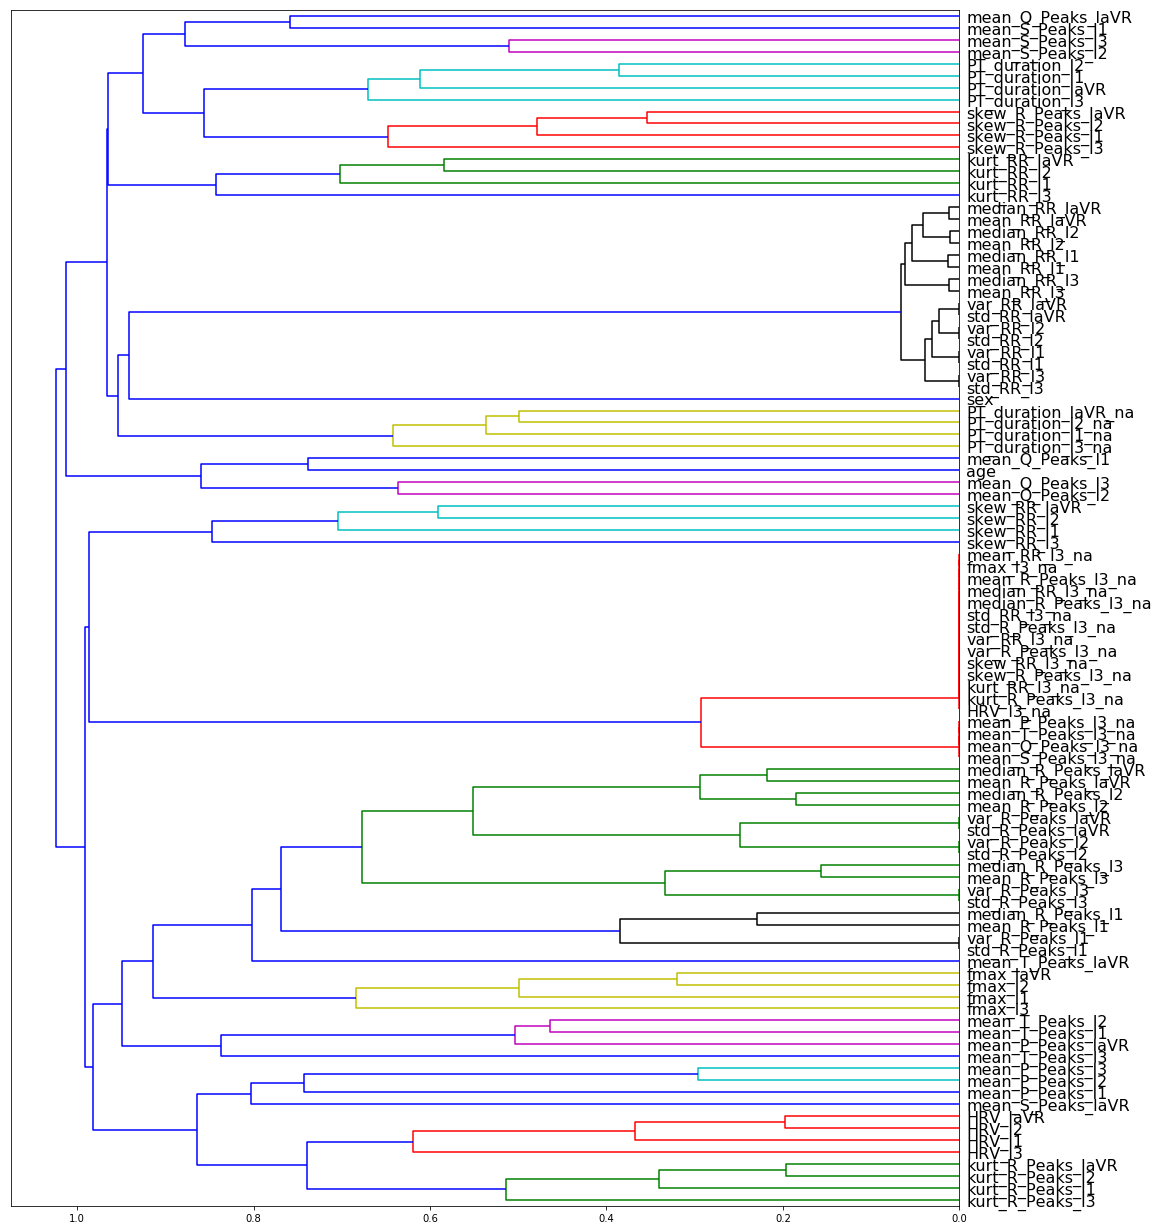

In [29]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(17,22))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [31]:
to_drop = ['var_RR_l1', 'var_R_Peaks_l1', 'var_RR_l2', 'var_R_Peaks_l2', 'var_RR_l3', 'var_R_Peaks_l3', 'var_RR_laVR', 'var_R_Peaks_laVR']
X_train_drop = X_train.drop(to_drop, axis=1)
X_valid_drop = X_valid.drop(to_drop, axis=1)

In [77]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_drop, y_train)

print_fscores(m_af, X_valid_drop, y_valid)

CPU times: user 52.9 s, sys: 285 ms, total: 53.2 s
Wall time: 9.63 s
[0.9338597731096968, 0.9814879497031085]


In [78]:
mlflow.set_experiment('AF_multiple_leads_feature_testing')
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_drop.columns)))
    mlflow.log_metric('f1_score', f1_score(y_valid, m_af.predict(X_valid_drop), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_valid, m_af.predict(X_valid_drop), beta=2))
    #mlflow.sklearn.log_model(m_af, "Model")

## Looking at Feature Importance

We calculate the feature importance using the MDI (Mean Decrease in Impurity) method, with is the default for sklearn's Random Forests

In [35]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,8), legend=False)

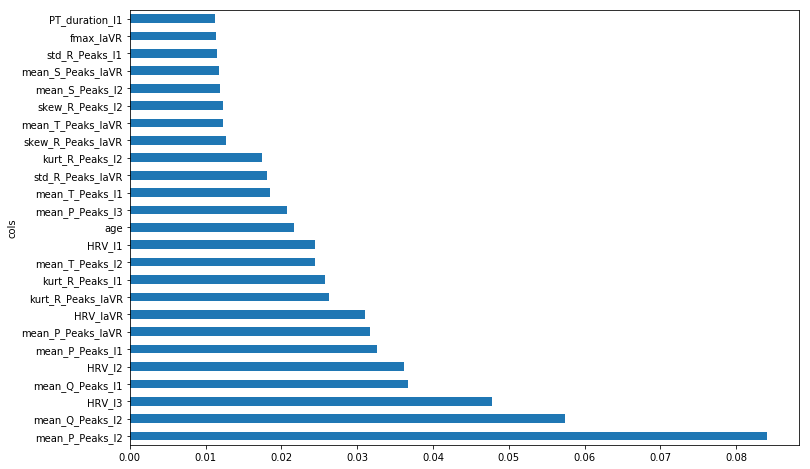

In [37]:
fi_mdi = rf_feat_importance(m_af, X_train_drop)
plot_fi(fi_mdi[:25]);

We now calculate feature importance using the MDA (Mean Decrease in Accuracy) method to compare. We can pass our own score algorithm so we will use the beta score since is the metric we will be optimizing to.

For more information on how these are calculated please refer to [this link](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3).

In [39]:
from sklearn.inspection import permutation_importance

score_f = make_scorer(fbeta_score, beta=2)

%time res = permutation_importance(m_af, X_train_drop, y_train, scoring=score_f, n_repeats=5, random_state=42, n_jobs=7)

CPU times: user 2min 6s, sys: 7.34 s, total: 2min 13s
Wall time: 3min 57s


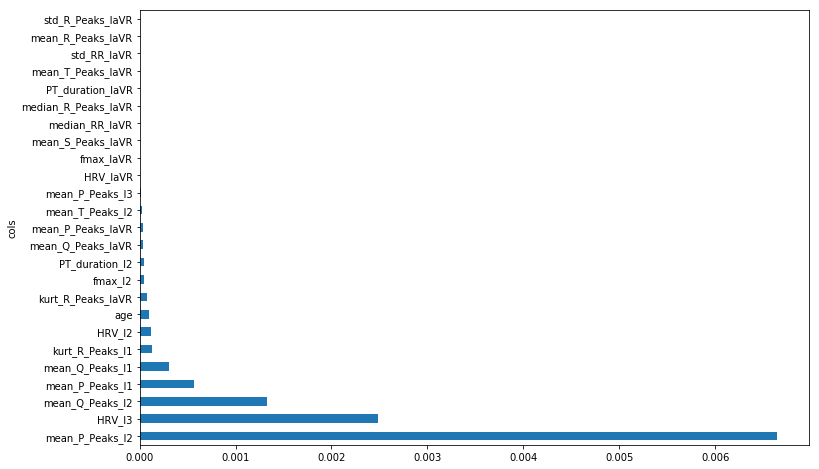

In [41]:
fi_mda = pd.DataFrame({'cols':X_train_drop.columns, 'imp':res.importances_mean.T}).sort_values('imp', ascending=False)

plot_fi(fi_mda[:25]);

### Lets optimize our model based on MDI results

In [73]:
thresh = 0.01
to_keep = list(fi_mdi[fi_mdi['imp'] > thresh].cols)

X_train_keep = X_train[to_keep]
X_valid_keep = X_valid[to_keep]

len(to_keep)

32

In [74]:
m_af = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, max_features='sqrt', n_jobs=7, oob_score=True)

%time m_af.fit(X_train_keep, y_train)

print_fscores(m_af, X_valid_keep, y_valid)

CPU times: user 20.9 s, sys: 164 ms, total: 21.1 s
Wall time: 4.25 s
[0.9428730313040565, 0.980546792849632]


In [75]:
mlflow.set_experiment('AF_multiple_leads_feature_testing')
with mlflow.start_run() as run:
    mlflow.log_params({'n_estimators': '1000', 'min_samples_leaf': '1', 'max_features': 'sqrt'})
    mlflow.log_param('n_Features', len(list(X_train_keep.columns)))
    mlflow.log_param('threshold', thresh)
    mlflow.log_metric('f1_score', f1_score(y_valid, m_af.predict(X_valid_keep), average='weighted'))
    mlflow.log_metric('f2_score', fbeta_score(y_valid, m_af.predict(X_valid_keep), beta=2))
    # mlflow.sklearn.log_model(m_af, "Model")
                      

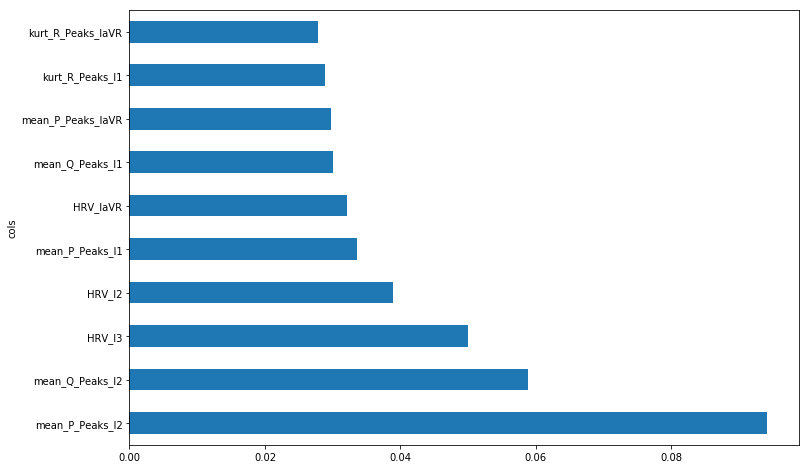

In [33]:
fi_mdi = rf_feat_importance(m_af, X_train_drop)
plot_fi(fi_mdi[:10]);